<a href="https://colab.research.google.com/github/IMOKURI/signate-471/blob/main/%E5%8C%BB%E5%AD%A6%E8%AB%96%E6%96%87%E3%81%AE%E8%87%AA%E5%8B%95%E4%BB%95%E5%88%86%E3%81%91%E3%83%81%E3%83%A3%E3%83%AC%E3%83%B3%E3%82%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this notebook ...

competition site: https://signate.jp/competitions/471







## ToDo

### Idea

- [ ] 分類で推論、回帰で推論
- [x] 回帰の場合の境界値の最適化
    - [ ] second stage で学習べきかも
- [ ] アブストで事前学習して、タイトルでメイン学習 https://www.kaggle.com/maunish/clrp-pytorch-roberta-pretrain
- [x] タイトルだけで学習・推論
- [ ] タイトル + アブストで学習・推論
    - [ ] タイトルだけで推論したのとアンサンブルができる
- [ ] アブストが空 or not でモデルわける
- [ ] アブストの max length 調整
    - [ ] 途中で切る
    - [ ] 要約する方法があるかなぁ
- [ ] 出現する単語のクラスタリング



## Prepare for Colab

In [1]:
!nvidia-smi

Fri Jul 30 06:37:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    37W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys

if os.path.exists('init.txt'):
    print("Already initialized.")

else:
    if 'google.colab' in sys.modules:
        from google.colab import drive
        drive.mount('/gdrive')

        !cp /gdrive/MyDrive/Datasets/signate-471/train.csv .
        !cp /gdrive/MyDrive/Datasets/signate-471/test.csv .
        !cp /gdrive/MyDrive/Datasets/signate-471/sample_submit.csv .

    # for StratifiedGroupKFold
    # !pip uninstall -y scikit-learn
    # !pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn

    # for MultilabelStratifiedKFold
    !pip install -q iterative-stratification

    # !pip install -qU 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'

    !pip install -q wandb
    !pip install -q transformers
    # !pip install textstat

    !touch init.txt

Already initialized.


## Library

In [3]:
import glob
import json
import math
import os
import random
import time
import warnings
from contextlib import contextmanager

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
# import textstat
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers as T
import wandb
# from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error, fbeta_score
from sklearn.model_selection import KFold, StratifiedKFold  # , StratifiedGroupKFold
from torch.optim import SGD, Adam  # , AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm


In [4]:
warnings.filterwarnings("ignore")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
netrc = "../input/wandbtoken/.netrc"

if 'google.colab' in sys.modules:
    netrc = "/gdrive/MyDrive/.netrc"

!cp -f {netrc} ~/

!wandb login

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [7]:
wandb_job_type = ""
wandb_notes = ""
wandb_tags = []

## Load Data

In [8]:
DATA_DIR = "../input/commonlitreadabilityprize/"
OUTPUT_DIR = "./"

if 'google.colab' in sys.modules:
    DATA_DIR = "./"

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [9]:
train = pd.read_csv(DATA_DIR + "train.csv")
test = pd.read_csv(DATA_DIR + "test.csv")
sub = pd.read_csv(DATA_DIR + "sample_submit.csv", header=None)
sub.columns = ["id", "judgement"]

## EDA

In [10]:
# アブストが空っぽのが結構ある

print(train.isnull().sum())
train.fillna("", inplace=True)

print(test.isnull().sum())
test.fillna("", inplace=True)

id              0
title           0
abstract     4390
judgement       0
dtype: int64
id             0
title          0
abstract    6546
dtype: int64


In [11]:
# title の単語数

train["len_title"] = train["title"].apply(lambda x: len(x.split()))
test["len_title"] = test["title"].apply(lambda x: len(x.split()))

print(train["len_title"].max())
print(test["len_title"].max())

53
69


In [12]:
# abstract の単語数

train["len_abstract"] = train["abstract"].apply(lambda x: len(x.split()))
test["len_abstract"] = test["abstract"].apply(lambda x: len(x.split()))

print(train["len_abstract"].max())
print(test["len_abstract"].max())

1535
1445


In [13]:
# abstract のあるなしを StratifiedKFold に使う

train["nan_abstract"] = np.where(train["len_abstract"] == 0, 1, 0)

In [14]:
# title と abstract を結合

train["title_abstract"] = train[["title", "abstract"]].agg(" ".join, axis=1)
test["title_abstract"] = test[["title", "abstract"]].agg(" ".join, axis=1)

train["len_title_abstract"] = train["title_abstract"].apply(lambda x: len(x.split()))
test["len_title_abstract"] = test["title_abstract"].apply(lambda x: len(x.split()))

print(train["len_title_abstract"].max())
print(test["len_title_abstract"].max())

1537
1457


In [15]:
for ds in [train, test, sub]:
    print(f"=" * 80)
    ds.info()
    display(ds.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27145 entries, 0 to 27144
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  27145 non-null  int64 
 1   title               27145 non-null  object
 2   abstract            27145 non-null  object
 3   judgement           27145 non-null  int64 
 4   len_title           27145 non-null  int64 
 5   len_abstract        27145 non-null  int64 
 6   nan_abstract        27145 non-null  int64 
 7   title_abstract      27145 non-null  object
 8   len_title_abstract  27145 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.9+ MB


,id,title,abstract,judgement,len_title,len_abstract,nan_abstract,title_abstract,len_title_abstract
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,10,193,0,One-year age changes in MRI brain volumes in o...,203
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,23,214,0,Supportive CSF biomarker evidence to enhance t...,237
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,10,133,0,Occurrence of basal ganglia germ cell tumors w...,143
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,13,374,0,New developments in diagnosis and therapy of C...,387
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,,0,16,0,1,Prolonged shedding of SARS-CoV-2 in an elderly...,16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40834 entries, 0 to 40833
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  40834 non-null  int64 
 1   title               40834 non-null  object
 2   abstract            40834 non-null  object
 3   len_title           40834 non-null  int64 
 4   len_abstract        40834 non-null  int64 
 5   title_abstract      40834 non-null  object
 6   len_title_abstract  40834 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 2.2+ MB


,id,title,abstract,len_title,len_abstract,title_abstract,len_title_abstract
0,27145,Estimating the potential effects of COVID-19 p...,The objective of the paper is to analyse chang...,16,245,Estimating the potential effects of COVID-19 p...,261
1,27146,Leukoerythroblastic reaction in a patient with...,,8,0,Leukoerythroblastic reaction in a patient with...,8
2,27147,[15O]-water PET and intraoperative brain mappi...,[15O]-water PET was performed on 12 patients w...,14,315,[15O]-water PET and intraoperative brain mappi...,329
3,27148,Adaptive image segmentation for robust measure...,We present a method that significantly improve...,11,119,Adaptive image segmentation for robust measure...,130
4,27149,Comparison of Epidemiological Variations in CO...,The objective of this study is to compare the ...,13,224,Comparison of Epidemiological Variations in CO...,237


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40834 entries, 0 to 40833
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         40834 non-null  int64
 1   judgement  40834 non-null  int64
dtypes: int64(2)
memory usage: 638.2 KB


,id,judgement
0,27145,0
1,27146,1
2,27147,1
3,27148,0
4,27149,1


### 目的変数 judgement の分布

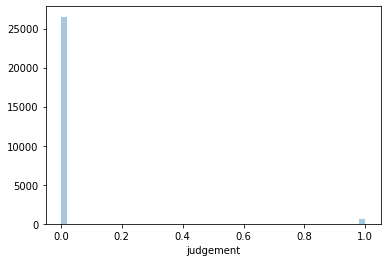

In [16]:
sns.distplot(train["judgement"], kde=False)

In [17]:
train["judgement"].value_counts()

0    26513
1      632
Name: judgement, dtype: int64

In [18]:
border = len(train[train["judgement"] == 1]) / len(train["judgement"])
print(border)

0.023282372444280715


### title の単語数の分布

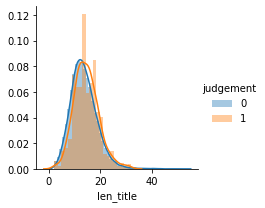

In [19]:
g = sns.FacetGrid(train[["judgement", "len_title"]], hue='judgement')
g.map(sns.distplot, 'len_title', label='judgement', hist=True, rug=False)
g.add_legend()

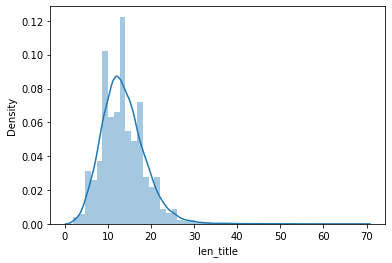

In [20]:
sns.distplot(test["len_title"], hist=True, rug=False)

### title + abstract の単語数の分布

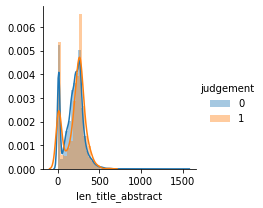

In [21]:
g = sns.FacetGrid(train[["judgement", "len_title_abstract"]], hue='judgement')
g.map(sns.distplot, 'len_title_abstract', label='judgement', hist=True, rug=False)
g.add_legend()

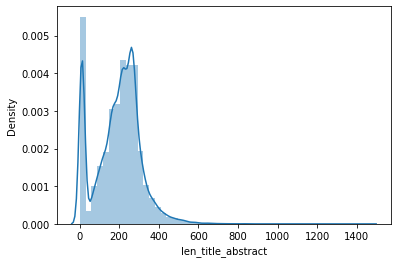

In [22]:
sns.distplot(test["len_title_abstract"], hist=True, rug=False)

## Config

In [23]:
class Config:
    wandb_entity = "imokuri"
    wandb_project = "signate-471"
    print_freq = 100

    train = False
    validate = True
    inference = True

    debug = False
    multi_gpu = False
    apex = False


In [24]:
if Config.train:
    wandb_job_type = "training"

elif Config.inference:
    wandb_job_type = "inference"

elif Config.validate:
    wandb_job_type = "validation"

In [25]:
if Config.apex:
    from apex import amp

In [26]:
# seed = random.randrange(10000)
seed = 440

print(seed)

440


In [27]:
config_defaults = {
    "seed": seed,
    "input": "title", # "title_abstract",
    "max_len": 72,
    "border": "minimize", # "fixed", "minimize",
    "n_class": 1,
    "n_fold": 5,
    "gradient_accumulation_steps": 1,
    "max_grad_norm": 1000,
    "num_workers": 4,
    "batch_size": 16,
    "epochs": 3,
    "optimizer": "BertAdamW",
    "scheduler": "get_cosine_schedule_with_warmup",
    "criterion": "BCEWithLogitsLoss",
    "lr": 2e-5,
    "min_lr": 1e-5,
    "weight_decay": 0.01,
    "model_name": "bert-base-uncased",  # "roberta-base", 
    "inference_runs": [
        "11pgifed", # 13
    ],
}


In [28]:
tokenizer = T.AutoTokenizer.from_pretrained(config_defaults["model_name"])

In [29]:
if not Config.validate and not Config.inference:
    config_defaults["inference_runs"] = []

In [30]:
if Config.debug:
    config_defaults["epochs"] = 1
    Config.print_freq = 10

In [31]:
if config_defaults["optimizer"] == "BertAdamW":
    config_defaults["lr_69"] = 5e-5
    config_defaults["lr_133"] = 1e-4


In [32]:
# Update by epoch
# num_steps = config_defaults["epochs"]

# Update by batch
num_data = 1000 if Config.debug else len(train)
num_steps = num_data // config_defaults["n_fold"] * (config_defaults["n_fold"] - 1) // config_defaults["batch_size"] // config_defaults["gradient_accumulation_steps"] * config_defaults["epochs"]

print(num_steps)

if config_defaults["scheduler"] == "CosineAnnealingWarmRestarts":
    config_defaults["T_0"] = num_steps

elif config_defaults["scheduler"] == "CosineAnnealingLR":
    config_defaults["T_max"] = num_steps

elif config_defaults["scheduler"] == "ReduceLROnPlateau":
    config_defaults["factor"] = 0.2
    config_defaults["patience"] = 4
    config_defaults["eps"] = 1e-6

elif config_defaults["scheduler"] == "CosineAnnealingWarmupRestarts":
    config_defaults["first_cycle_steps"] = num_steps
    config_defaults["warmup_steps"] = num_steps // 10

elif config_defaults["scheduler"] == "get_cosine_schedule_with_warmup":
    config_defaults["num_training_steps"] = num_steps
    config_defaults["num_warmup_steps"] = max(50, num_steps // 10)

4071


In [33]:
if Config.debug:
    wandb.init(project=Config.wandb_project, config=config_defaults, mode="disabled")
else:
    wandb.init(project=Config.wandb_project, config=config_defaults, notes=wandb_notes, tags=wandb_tags, job_type=wandb_job_type, save_code=True)

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [34]:
config = wandb.config

## Load Models

In [35]:
if Config.validate:
    api = wandb.Api()

    for n, run_id in enumerate(config.inference_runs):
        if not os.path.exists(run_id):
            os.makedirs(run_id)

        run_path = f"{Config.wandb_entity}/{Config.wandb_project}/{run_id}"
        run = api.run(run_path)

        try:
            run.file("oof_df.csv").download(run_id)
        except wandb.CommError:
            # Already downloaded.
            pass

        oof = pd.read_csv(f"{run_id}/oof_df.csv")[["id", "preds"]]
        oof.columns = ["id", f"preds{n}"]
        train = pd.merge(train, oof, on="id")
    
    print(train.columns)

Index(['id', 'title', 'abstract', 'judgement', 'len_title', 'len_abstract',
       'nan_abstract', 'title_abstract', 'len_title_abstract', 'preds0'],
      dtype='object')


In [36]:
if Config.inference:
    api = wandb.Api()
    inference_models = []

    for n, run_id in enumerate(config.inference_runs):
        if not os.path.exists(run_id):
            os.makedirs(run_id)

        run_path = f"{Config.wandb_entity}/{Config.wandb_project}/{run_id}"
        run = api.run(run_path)

        inference_model = {}
        inference_model["run_id"] = run_id
        inference_model["model_name"] = run.config["model_name"]

        for fold in range(config.n_fold):
            try:
                run.file(f"{inference_model['model_name']}_fold{fold}_best.pth").download(run_id)
            except wandb.CommError:
                # Already downloaded.
                pass

            model_preds = torch.load(f"{run_id}/{inference_model['model_name']}_fold{fold}_best.pth")
            inference_model[f"state_fold{fold}"] = model_preds["model"]
            inference_model[f"preds_fold{fold}"] = model_preds["preds"]

        inference_models.append(inference_model)
    
    print({m['run_id']: m['model_name'] for m in inference_models})

{'11pgifed': 'bert-base-uncased'}


In [37]:
if Config.debug:
    train = train.sample(n=1000, random_state=config.seed).reset_index(drop=True)
    test = test.sample(n=1000, random_state=config.seed).reset_index(drop=True)
    sub = sub.sample(n=1000, random_state=config.seed).reset_index(drop=True)

## Utils

In [38]:
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=config.seed)


## CV Split

In [39]:
folds = train.copy()
Fold = MultilabelStratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[["judgement", "nan_abstract"]])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(np.uint8)
print(folds.groupby(["fold", "judgement", "nan_abstract"]).size())
# print(folds.groupby(["fold"]).size())


fold  judgement  nan_abstract
0     0          0               4456
                 1                847
      1          0                 95
                 1                 31
1     0          0               4444
                 1                858
      1          0                107
                 1                 20
2     0          0               4456
                 1                847
      1          0                 95
                 1                 31
3     0          0               4441
                 1                862
      1          0                110
                 1                 16
4     0          0               4448
                 1                854
      1          0                103
                 1                 24
dtype: int64


## Dataset

In [40]:
class BaseDataset(Dataset):
    def __init__(self, df, include_labels=True):
        self.df = df
        self.include_labels = include_labels

        self.title = df[config.input].tolist()
        self.encoded = tokenizer.batch_encode_plus(
            self.title,
            padding = 'max_length',            
            max_length = config.max_len,
            truncation = True,
            return_attention_mask=True
        )
        
        if self.include_labels:
            self.labels = df["judgement"].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.encoded['input_ids'][idx])
        attention_mask = torch.tensor(self.encoded['attention_mask'][idx])

        if self.include_labels:
            label = torch.tensor(self.labels[idx]).float()
            return input_ids, attention_mask, label

        return input_ids, attention_mask


In [41]:
# Test

train_ds = BaseDataset(train)

for i in range(1):
    input_ids, attention_mask, label = train_ds[i]
    print(input_ids)
    print(attention_mask)
    print(f"label: {label}")


tensor([  101,  2028,  1011,  2095,  2287,  3431,  1999, 27011,  4167,  6702,
         1999,  3080,  6001,  1012,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
label: 0.0


## Model

In [42]:
T.AutoConfig.from_pretrained(config.model_name)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [43]:
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()

        if config.model_name in ["roberta-base", "bert-base-uncased"]:
            out_dim = 768
        elif config.model_name == "roberta-large":
            out_dim = 1024

        auto_config = T.AutoConfig.from_pretrained(config.model_name)
        auto_config.update({
            "output_hidden_states": True,
            # "hidden_dropout_prob": 0.1,
            # "layer_norm_eps": 1e-7,
        })
        
        self.auto_model = T.AutoModel.from_pretrained(config.model_name, config=auto_config)  

        self.attention = nn.Sequential(
            nn.Linear(out_dim, 512),            
            nn.Tanh(),                       
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )        

        self.regressor = nn.Sequential(
            nn.Linear(out_dim, 1)                        
        )

    def forward(self, input_ids, attention_mask):
        bert_output = self.auto_model(input_ids=input_ids, attention_mask=attention_mask)        

        # There are a total of 13 layers of hidden states.
        # 1 for the embedding layer, and 12 for the 12 Roberta layers.
        # We take the hidden states from the last Roberta layer.
        last_layer_hidden_states = bert_output.hidden_states[-1]

        # The number of cells is config.max_len.
        # The size of the hidden state of each cell is 768 (for roberta-base).
        # In order to condense hidden states of all cells to a context vector,
        # we compute a weighted average of the hidden states of all cells.
        # We compute the weight of each cell, using the attention neural network.
        weights = self.attention(last_layer_hidden_states)
                
        # weights.shape is config.batch_size x config.max_len x 1
        # last_layer_hidden_states.shape is config.batch_size x config.max_len x 768        
        # Now we compute context_vector as the weighted average.
        # context_vector.shape is config.batch_size x 768
        context_vector = torch.sum(weights * last_layer_hidden_states, dim=1)        
        
        # Now we reduce the context vector to the prediction score.
        out = self.regressor(context_vector).squeeze()

        return out

In [44]:
# Test

model = BaseModel()
print(model)

train_dataset = BaseDataset(train)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

for input_ids, attention_mask, labels in train_loader:
    output = model(input_ids, attention_mask)
    print(output)
    break


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BaseModel(
  (auto_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [45]:
# Test

for n, (name, tensor) in enumerate(list(model.named_parameters())):
    print(f"{n}: {name}")

0: auto_model.embeddings.word_embeddings.weight
1: auto_model.embeddings.position_embeddings.weight
2: auto_model.embeddings.token_type_embeddings.weight
3: auto_model.embeddings.LayerNorm.weight
4: auto_model.embeddings.LayerNorm.bias
5: auto_model.encoder.layer.0.attention.self.query.weight
6: auto_model.encoder.layer.0.attention.self.query.bias
7: auto_model.encoder.layer.0.attention.self.key.weight
8: auto_model.encoder.layer.0.attention.self.key.bias
9: auto_model.encoder.layer.0.attention.self.value.weight
10: auto_model.encoder.layer.0.attention.self.value.bias
11: auto_model.encoder.layer.0.attention.output.dense.weight
12: auto_model.encoder.layer.0.attention.output.dense.bias
13: auto_model.encoder.layer.0.attention.output.LayerNorm.weight
14: auto_model.encoder.layer.0.attention.output.LayerNorm.bias
15: auto_model.encoder.layer.0.intermediate.dense.weight
16: auto_model.encoder.layer.0.intermediate.dense.bias
17: auto_model.encoder.layer.0.output.dense.weight
18: auto_model

## Optimizer

In [46]:
def bert_optimizer(model):
    named_parameters = list(model.named_parameters())    
    
    if config.model_name in ["roberta-base", "bert-base-uncased"]:
        bert_parameters = named_parameters[:197]    
        attention_parameters = named_parameters[199:203]
        regressor_parameters = named_parameters[203:]
        second_block = 69
        third_block = 133

    elif config.model_name == "roberta-large":
        bert_parameters = named_parameters[:388]    
        attention_parameters = named_parameters[391:395]
        regressor_parameters = named_parameters[395:]
        second_block = 133
        third_block = 261
        
    attention_group = [params for (name, params) in attention_parameters]
    regressor_group = [params for (name, params) in regressor_parameters]

    parameters = []
    parameters.append({"params": attention_group})
    parameters.append({"params": regressor_group})

    for layer_num, (name, params) in enumerate(bert_parameters):
        weight_decay = 0.0 if "bias" in name else config.weight_decay

        lr = config.lr

        if layer_num >= second_block:        
            lr = config.lr_69

        if layer_num >= third_block:
            lr = config.lr_133

        parameters.append({"params": params, "weight_decay": weight_decay, "lr": lr})

    return T.AdamW(parameters)


## Loss

In [47]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

## Scoring

In [48]:
def get_score(y_true, y_pred, b=border):
    y_pred = np.where(y_pred < b, 0, 1)
    return fbeta_score(y_true, y_pred, beta=7.0)

In [49]:
def get_result(result_df, fold=config.n_fold):
    preds = result_df["preds"].values
    labels = result_df["judgement"].values
    score = get_score(labels, preds)
    LOGGER.info(f"Score: {score:<.5f}")
    # wandb.log({"fold": fold, "CV": score})
    if fold == config.n_fold:
        wandb.run.summary[f"CV"] = score
    else:
        wandb.run.summary[f"CV_fold{fold}"] = score


In [50]:
def determine_border(b, y_true, y_pred):
    return -1 * get_score(y_true, y_pred, b)


## Helper functions

In [51]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [52]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()

    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    optimizer.zero_grad()

    for step, (input_ids, attention_mask, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        y_preds = model(input_ids, attention_mask)

        loss = criterion(y_preds, labels)

        # record loss
        losses.update(loss.item(), batch_size)
        if config.gradient_accumulation_steps > 1:
            loss = loss / config.gradient_accumulation_steps
        if Config.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

        if (step + 1) % config.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()
            
            global_step += 1

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % Config.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.avg:.4f} "
                f"Grad: {grad_norm:.4f} "
                # f"LR: {scheduler.get_last_lr()[0]:.6f}  "
                f"LR: {scheduler.get_lr()[0]:.6f}  "
            )

    return losses.avg

In [53]:
def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()

    for step, (input_ids, attention_mask, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # compute loss
        with torch.no_grad():
            y_preds = model(input_ids, attention_mask)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # record score
        # preds.append(y_preds.softmax(1).to("cpu").numpy())
        preds.append(y_preds.to("cpu").numpy())
        if config.gradient_accumulation_steps > 1:
            loss = loss / config.gradient_accumulation_steps

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % Config.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.avg:.4f} "
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [54]:
def inference(test_loader):
    predictions = []
    for model_item in inference_models:
        for fold in range(config.n_fold):
            LOGGER.info(f"========== ID: {model_item['run_id']} model: {model_item['model_name']} fold: {fold} inference ==========")
            model = BaseModel()
            model.to(device)
            model.load_state_dict(model_item[f"state_fold{fold}"])
            model.eval()
            preds = []
            for i, (input_ids, attention_mask) in enumerate(test_loader):
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                with torch.no_grad():
                    y_preds = model(input_ids, attention_mask)
                # avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
                preds.append(y_preds.to("cpu").numpy())
            preds = np.concatenate(preds)
            predictions.append(preds)
    predictions = np.mean(predictions, axis=0)

    if config.criterion == "BCEWithLogitsLoss":
        predictions = 1 / (1 + np.exp(-predictions))

    return predictions


## Train loop

In [55]:
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds)
    valid_dataset = BaseDataset(valid_folds)

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Optimizer
    # ====================================================
    def get_optimizer(model):
        if config.optimizer == "Adam":
            optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay, amsgrad=False)
        elif config.optimizer == "AdamW":
            optimizer = T.AdamW(model.parameters(), lr=config.lr)  # , weight_decay=config.weight_decay, amsgrad=False
        elif config.optimizer == "BertAdamW":
            optimizer = bert_optimizer(model)
        return optimizer

    # ====================================================
    # Scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if config.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=config.factor, patience=config.patience, verbose=True, eps=config.eps
            )
        elif config.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=config.T_max, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(
                optimizer, T_0=config.T_0, T_mult=1, eta_min=config.min_lr, last_epoch=-1
            )
        elif config.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer, first_cycle_steps=config.first_cycle_steps, max_lr=config.lr, min_lr=config.min_lr, warmup_steps=config.warmup_steps
            )
        elif config.scheduler == "get_cosine_schedule_with_warmup":
            scheduler = T.get_cosine_schedule_with_warmup(
                optimizer,
                num_training_steps=config.num_training_steps, 
                num_warmup_steps=config.num_warmup_steps
            )
        return scheduler

    # ====================================================
    # Model
    # ====================================================
    model = BaseModel()
    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and not Config.apex and Config.multi_gpu:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = get_optimizer(model)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # Apex
    # ====================================================
    if Config.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if config.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif config.criterion == "BCEWithLogitsLoss":
            criterion = nn.BCEWithLogitsLoss()
        elif config.criterion == "MSELoss":
            criterion = nn.MSELoss()
        elif config.criterion == "RMSELoss":
            criterion = RMSELoss()

        return criterion

    criterion = get_criterion()

    # ====================================================
    # Loop
    # ====================================================
    best_score = -1
    best_loss = np.inf

    # if not Config.multi_gpu:
    #     wandb.watch(model, log_freq=Config.print_freq)

    for epoch in range(config.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["judgement"].values

        # if isinstance(scheduler, ReduceLROnPlateau):
        #     scheduler.step(avg_val_loss)
        # else:
        #     scheduler.step()

        if config.criterion == "BCEWithLogitsLoss":
            preds = 1 / (1 + np.exp(-preds))

        # scoring
        # score = get_score(valid_labels, preds.argmax(1))
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

        wandb.log(
            {
                "epoch": epoch + 1,
                f"loss/train_fold{fold}": avg_loss,
                f"loss/val_fold{fold}": avg_val_loss,
                f"score/fold{fold}": score,
            }
        )

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{config.model_name}_fold{fold}_best.pth"
            )
            wandb.save(OUTPUT_DIR + f"{config.model_name}_fold{fold}_best.pth")

        # if epoch == config.epochs - 1:
        #     LOGGER.info(f"Epoch {epoch+1} - Save final model")
        #     torch.save(
        #         {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{config.model_name}_fold{fold}_final.pth"
        #     )

    check_point = torch.load(OUTPUT_DIR + f"{config.model_name}_fold{fold}_best.pth")

    valid_folds[[str(c) for c in range(config.n_class)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"]  # .argmax(1)

    return valid_folds

## Main


In [56]:
def main():
    if Config.train:
        oof_df = pd.DataFrame()
        for fold in range(config.n_fold):
            seed_torch(seed + fold)

            _oof_df = train_loop(folds, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, fold)
            
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")
        
    if Config.validate:
        probs = []

        for n in range(len(config.inference_runs)):
            probs.append(train[f"preds{n}"].values)
        preds = np.mean(probs, axis=0)
        train["preds"] = preds

        # Post process
        if config.border == "minimize":
            res = sp.optimize.minimize_scalar(determine_border, method='bounded', bounds=(0, 1), args=(train["judgement"].values, preds))
            LOGGER.info(f"========== Border Optimization ==========")
            LOGGER.info(f"Border: {res.x:<.5f}, Score: {-res.fun:<.5f}")
            wandb.run.summary[f"CV"] = -res.fun

        elif config.border == "fixed":
            # CV result
            LOGGER.info(f"========== CV ==========")
            get_result(train)

        # save result
        train.to_csv(OUTPUT_DIR + "validation_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "validation_df.csv")

    if Config.inference:
        test_dataset = BaseDataset(test, include_labels=False)
        test_loader = DataLoader(
            test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True
        )
        predictions = inference(test_loader)

        # Post process
        try:
            b = res.x
        except Exception:
            b = border
        wandb.run.summary[f"border"] = b

        predictions = np.where(predictions < b, 0, 1)

        # submission
        sub["judgement"] = predictions  # .argmax(1)
        print(sub["judgement"].value_counts())

        sub.to_csv(OUTPUT_DIR + "submission.csv", index=False, header=False)
        wandb.save(OUTPUT_DIR + "submission.csv")


In [57]:
if __name__ == "__main__":
    main()


========== Border Optimization ==========
Border: 0.00872, Score: 0.84791
========== ID: 11pgifed model: bert-base-uncased fold: 0 inference ==========
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
===

0    37420
1     3414
Name: judgement, dtype: int64


In [58]:
wandb.finish()

CV,0.84791
border,0.00872


## Public LB

In [59]:
RUN_ID = "None"
LB_SCORE = None

WANDB_ENTITY = "imokuri"
WANDB_PROJECT = "signate-471"

In [60]:
if RUN_ID is not None and LB_SCORE is not None:
    import wandb
    api = wandb.Api()

    run = api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{RUN_ID}")
    run.summary["LB"] = LB_SCORE
    run.summary.update()
